## CS 5990: Advanced Machine Learning Final Project
## Mish Wilson and Cooper Sullivan

### 10/23/2024

## READ ME

**Firstly downloaded required libraries using:**

pip install -r requirements.txt

**Then to install pytorch and tourch audio, run:**

pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from IPython.display import Audio
from numpy.fft import fft, ifft
from os.path import dirname, join as pjoin
import os
import pandas as pd
from torchvision.io import read_image

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

%matplotlib inline

import math, random
from pathlib import Path
import torch
import torchaudio
from torchaudio import transforms
import soundfile

torchaudio.set_audio_backend("soundfile")

import seaborn as sn

c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Snoop\AppData\Local\Temp\ipykernel_22312\452284249.py:28: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


## Download Dataset

Download Dataset from Kaggle [https://www.kaggle.com/datasets/mashijie/eating-sound-collection]
Ensure that clips_rd folder is inside of ML-audio-chef folder. So hiearchy is: ML-audio-chef/clips_rd/aloe.....

# Audio Functions

Here we transform the data so that its in a format the model expects. This can be done during runtime. Audio files tend to be large- so we're keeping only the audio file names in our taining data.

Then at run time, as we train the model we plan on loading in the audio data for that batch and then process it. This way we keep audio data for only one batch in memory at a time reducing the overall strain on system by loading everything in all at once and without having to store it all!

The transformation we perform on our audio before training:

- **Transform Sample Rate**
    - Just looping through and making sure all the audio files have the same sample rate! Majority seem to be 44100Hz- but just to make sure I'll loop through to catch any that aren't.

- **Resizing Audio Lengths**
    - Resizing  samples to be the same length. Found that they are infact different lengths ranging between 2 and 4? I think I'll just average it out to 3 seconds each. Padding it out with silence if its 2 seconds and truncating if its 4? We can change this if this is bad.

- **Rechannel**
    - Rechanneling is mroe iche since audio files are assumed to be stero (2 or more channels) but just incase we decided to rechannel all of our audio to be mono channeled. Which is done by slicing off a channel, in the case of increasing the size we would duplicate the audio and truncate one again as needed.


- **Convert to Spectrogram**

- **Spectrogram Augmentation**
    - For specaugmentation we add a frequency mask and a time mask to our spectrograms.
        - Frequency Mask: Randomly Mask out a range of consecutive frequencies by adding horizonatal bars to our spectro gram
        - Time Mask: Randomly block out ranges of time from the spectrogram by using vertical bars.
    - We do this to prevent overfitting and to help the model generalize better. The masked sections get replaced with a mean value which is pretty cool!

In [88]:
# Group together audio opening function as well as audio transformation functions into a convenient class
class AudioFuncs():
    
    def open_audio(audio_file):
        signal, sample_rate = torchaudio.load(audio_file)
        return signal, sample_rate


    # Resample takes in audio file (aud) and desired sample rate (newsr) and ensures they match
    def resample(audio, newsr):
        signal, sr = audio

        if (sr == newsr):
            return audio
            
        # Resample channel
        re_signal = torchaudio.transforms.Resample(sr, newsr)(signal[:1,:])
    
        return ((re_signal, newsr))


    # Resize audio to be of specific time length (max_ms)
    def resize(aud, max_ms):
        signal, sample_rate = aud
        num_rows, signal_len = signal.shape

        # calculate what would make audio max_ms long
        max_len = sample_rate//1000 * max_ms

        if (signal_len > max_len):
            # Truncate signal
            signal = signal[:,:max_len]

        elif (signal_len < max_len):
            # Pad audio with silence instead. At beginning and end.
            pad_begin_len = random.randint(0, max_len - signal_len)
            pad_end_len = max_len - signal_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            signal = torch.cat((pad_begin, signal, pad_end), 1)
        
        return (signal, sample_rate)


    # Rechannel audio
    def rechannel(audio, max_channels):
        
        signal, sr = audio

        # Verify audio isn't already correct number of channels 
        if (signal.shape[0] == max_channels):
            return audio
        
        # If audio channels > max_channels -> Reduce channels to max_channels
        if (signal.shape[0] > max_channels):
            new_signal = signal[:max_channels, :]
            
        else:
            # Add bonus channels to get to max_channels
            new_signal = signal
            
            # Loop through initially duplicating/ doubling channels up to point before overflow
            while (new_signal.shape[0] + signal.shape[0]) < max_channels:
                new_signal = torch.cat([new_signal, signal])
            # After reaching number of channels before doubling would overflow just add single channel until reaching max_channels
            while new_signal.shape[0] < max_channels:
                new_signal = torch.cat([new_signal, signal[:1, :]])

        return (new_signal, sr)


    # Creates spectrogram for given audio sample with specified mel bins and Fourier transformations.
    def spectrogram(audio, n_mels=128, n_fft=1024, hop_len=None):
        signal, sample_rate = audio
        top_db = 80

        # spectrogram shape is [channel, n_mels, time]
        spec = transforms.MelSpectrogram(sample_rate, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(signal)

        # Convert to decibels 
        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return spec
    

    # Visualize given spectrogram (spec) with matplotlib
    def plot_spectrogram(spec, title='Spectrogram'):
        # Convert the tensor to a numpy array and squeeze to 2D
        spec = spec.squeeze().numpy()

        plt.figure(figsize=(10, 4))
        plt.imshow(spec, aspect='auto', origin='lower')
        plt.colorbar()
        plt.title(title)
        plt.xlabel('Time (frames)')
        plt.ylabel('Mel frequency bins')
        return plt
    

    # Mask a percentage of the given spectrogram with averaging data to in theory reduce overfitting when training data. 
    # Defaulting to 10% and only one mask until we deiscuss what would be most optional for generalizing :)
    def spec_mask(spec, max_mask_pct=0.1, num_freq_masks=1, num_time_masks=1):
        _, num_mels, num_steps = spec.shape
        
        # Get the average to replace the blocked zones
        mask_val = spec.mean()
        augment_spec = spec
        
        # Add frquency mask- will look like a horizonal bar
        freq_mask_param = max_mask_pct * num_mels
        for _ in range(num_freq_masks):
            augment_spec = transforms.FrequencyMasking(freq_mask_param)(augment_spec, mask_val)

        # Add time mask- will look like a vertical bar
        time_mask_param = max_mask_pct * num_steps
        for _ in range(num_time_masks):
            augment_spec = transforms.TimeMasking(time_mask_param)(augment_spec,mask_val)

        return augment_spec
   
    



### Initial Non-CNN Classification

We wanted to wait until be covered CNN's more in class before pursuing it full on, so in the mean time we decided to test our data on some Classifiers within sklearn. The classifiers we used were Decision Tree, SVC and Random Forest Classification. 

For the time being, before we set up a dataloader that will load our code in batched, we've decided to test our data on 20% of our dataset.

In [89]:
# Load data into tensorflow training and testing dataset after split
# Not attempting to load all data in at once due to the fact theres 11k of these audio files. 
# Will instead split dataset in half and use percentage out of that to train an initial model and see how it goes.
audio_files = []
audio_labels = []

# Keep track incase not all files are correctly loaded
success = 0
fail = 0

# Dataframe containing information about clips, including labels and relative_paths
df = pd.read_csv('metadeta.csv')

# Get every 4th row in dataset
for row in df[::5].iterrows():
    try:

        audio_path = row[1][0]
        audio_label = row[1][1]

        audio = AudioFuncs.open_audio(audio_path)
        trans_audio = AudioFuncs.resample(audio, 44100)
        trans_audio = AudioFuncs.rechannel(trans_audio, 1)
        trans_audio = AudioFuncs.resize(trans_audio, 3000)
        trans_audio = AudioFuncs.spectrogram(trans_audio)
        # trans_audio = AudioFuncs.spec_mask(trans_audio)
        spec = np.mean(np.array(trans_audio).T, axis=0)
        audio_files.append(spec)
        audio_labels.append(audio_label)

        success += 1
    except RuntimeError:
        fail += 1
        print(f"Skipping file: {audio}")
print(f"Successes: {success}\nFails: {fail}")


C:\Users\Snoop\AppData\Local\Temp\ipykernel_22312\981478235.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  audio_path = row[1][0]
C:\Users\Snoop\AppData\Local\Temp\ipykernel_22312\981478235.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  audio_label = row[1][1]
c:\Users\Snoop\OneDrive - University of Vermont\Documents\University of Vermont\Machine Learning\ML-audio-chef\.venv\lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warning

Successes: 2228
Fails: 0


In [31]:
# Resizing out audiofiles into a 2D array so that it can be passed into the Classification Models
audio_files= np.array(audio_files)
audio_labels = np.array(audio_labels)
nsamples, nx, ny = audio_files.shape

# Create logistic regression obj and do partial fit with individual batches.
x_train, x_test, y_train, y_test = train_test_split(audio_files.reshape((nsamples, nx*ny)), audio_labels, test_size=0.20, random_state=0)

models = [SVC(kernel='linear'), DecisionTreeClassifier(), RandomForestClassifier()]
scores = []

predictions = []
groundtruth = []
for model in models:
    model.fit(x_train, y_train)
    score = model.score(x_test, y_test)
    scores.append((type(model).__name__, (f'{100*score:.2f}%')))
    predictions.append(model.predict(x_test))
    groundtruth.append(y_test)

# Record Scores for our Classification Models
scores_df = pd.DataFrame(scores, columns=['Classifier', 'Accuracy Score'])
scores_df
    

,Classifier,Accuracy Score
0,SVC,46.41%
1,DecisionTreeClassifier,32.51%
2,RandomForestClassifier,52.24%


In [32]:
# Create a Confusion Matrix of the predictions versus the true results
def plot_confusion_matrix(groundtruth, predictions, food_categories, name):
    conf_matrix = confusion_matrix(groundtruth, predictions)
    conf_matrix_norm = confusion_matrix(groundtruth, predictions,normalize='true')

    # set labels for matrix axes from emotions
    food_list = food_categories
    food_name = [emotion for emotion in food_list]

    # make a confusion matrix with labels using a DataFrame
    confmatrix_df = pd.DataFrame(conf_matrix, index=food_name, columns=food_name)
    confmatrix_df_norm = pd.DataFrame(conf_matrix_norm, index=food_name, columns=food_name)

    # plot confusion matrices
    plt.figure(figsize=(16,6))
    sn.set(font_scale=1) # emotion label and title size
    plt.subplot(1,2,1)
    plt.title(f'Confusion Matrix {name}')
    sn.heatmap(confmatrix_df, annot=True, annot_kws={"size": 10}) #annot_kws is value font
    plt.subplot(1,2,2)
    plt.title('Normalized Confusion Matrix')
    sn.heatmap(confmatrix_df_norm, fmt='.2f', annot=True, annot_kws={"size": 7}) #annot_kws is value font

    plt.show()

## SVC Model

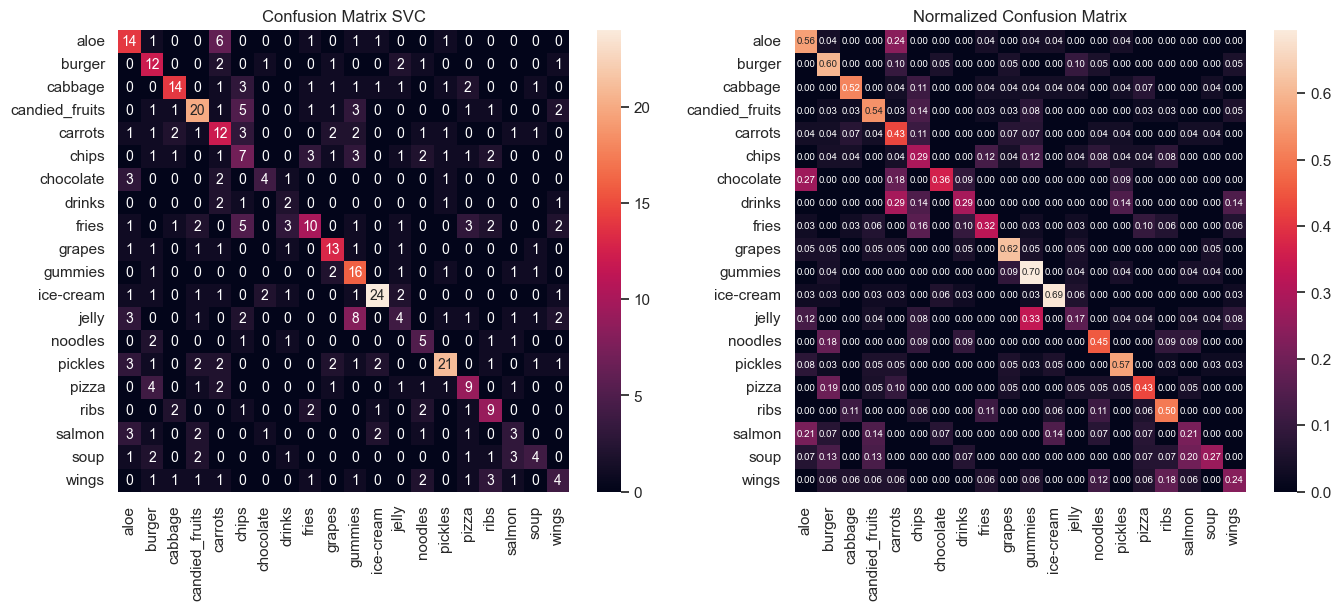

In [33]:

plot_confusion_matrix(groundtruth[0], predictions[0], os.listdir(os.getcwd() + "/clips_rd"), "SVC")

## Decision Tree Model

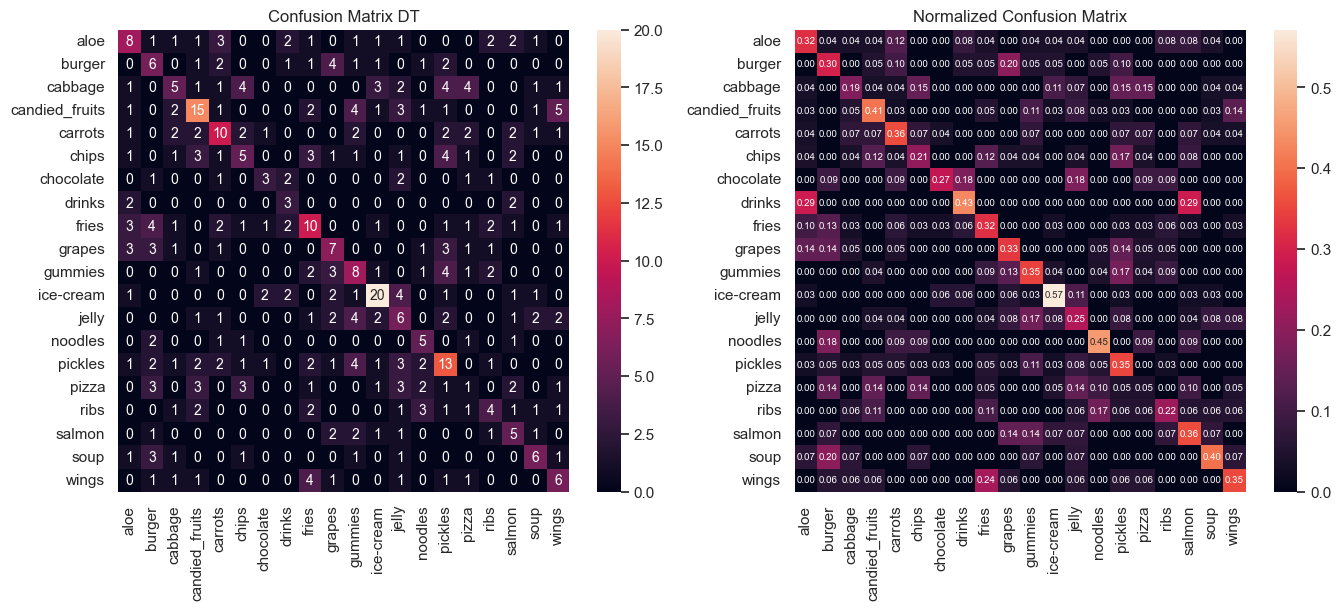

In [29]:
plot_confusion_matrix(groundtruth[1], predictions[1], os.listdir(os.getcwd() + "/clips_rd"), "DT")

## Random Forest Model

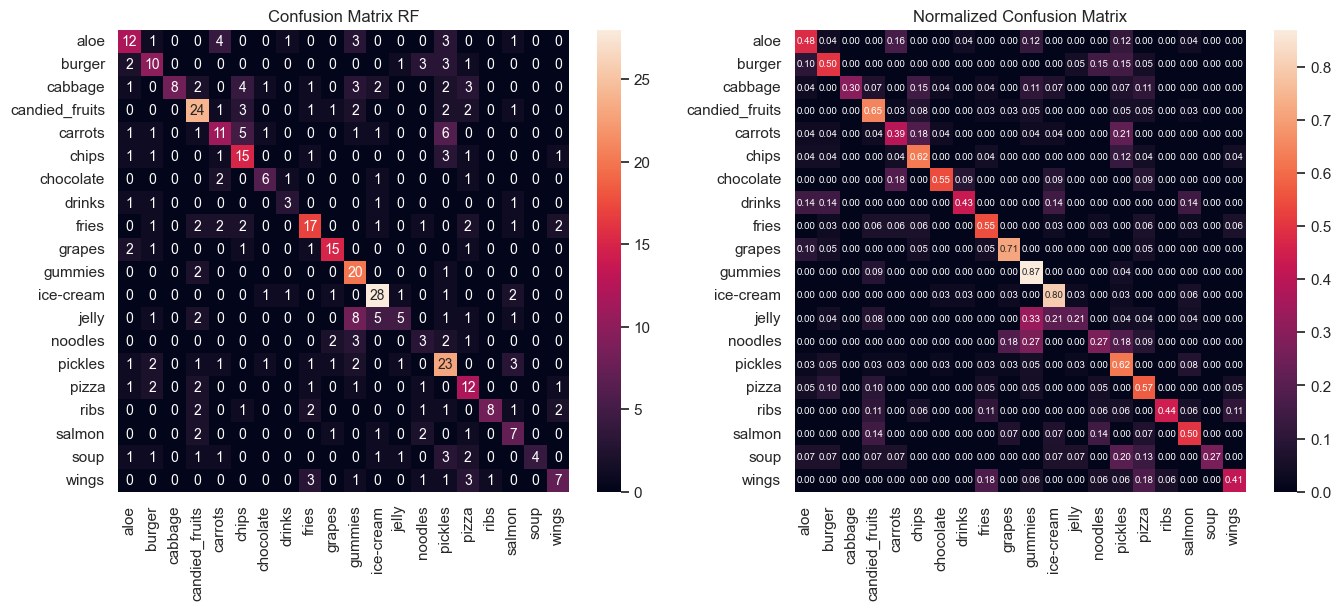

In [ ]:
plot_confusion_matrix(groundtruth[2], predictions[2], os.listdir(os.getcwd() + "/clips_rd"), "RF")